In [14]:
import geopandas as gpd
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error as mse

from mgwr.gwr import GWR

In [70]:
# import data
gdf = gpd.read_file('..\\output\\model_in1.GEOJSON', engine='pyogrio', use_arrow=True)
c_variables = ['x', 'y']
# x_variables = ['maxspeed', 'bridge', 'rt_tertiary', 'rt_residential', 'rt_living_street', 'rt_service']
x_variables = ['maxspeed', 'bridge']
y_variable = ['dBA_reg']


In [71]:
# create splits
gdf_train, gdf_test = train_test_split(gdf[gdf['dBA_reg'].notna()], test_size=0.2)
gdf_unknown = gdf[gdf['dBA_reg'].isna()]

In [73]:
# create inputs for each split
train_data, test_data, unkown_data = {}, {}, {}
scaler = StandardScaler()

for i, (d, gdf) in enumerate(((train_data, gdf_train), (test_data, gdf_test), (unkown_data, gdf_unknown))):
    d['x'] = scaler.fit_transform(  # TODO expirement with standardizations
                gdf[x_variables].astype('float64').values)
    if i < 2: d['y'] = gdf[y_variable].astype('int32').values
    d['c'] = scaler.fit_transform(gdf[c_variables].values)

In [75]:
# adding noise to prevent singular matrixes
m = train_data['x']
for i in range(m.shape[0]):
    m[i][i%m.shape[1]] += 0.0001
train_data['x'] = m

m = train_data['y']
for i in range(m.shape[0]):
    m[i][i%m.shape[1]] += 0.0001
train_data['y'] = m

In [77]:
# create a model based on train split
# TODO try to get bw_select working, play around with parameters
model = GWR(train_data['c'], train_data['y'], train_data['x'], bw=96, fixed=False, kernel='bisquare') # at bw=10 singular matrix error still occurs
train_results = model.fit()

mse(train_results.predy, train_data['y'])

LinAlgError: Matrix is singular.

In [65]:
# # predict test split, show MSE
scale = train_results.scale
residuals = train_results.resid_response

# model = GWR(train_data['c'], train_data['y'], train_data['x'], bw=94, fixed=False, kernel='bisquare')
test_results = model.predict(test_data['c'], test_data['x'], scale, residuals)
mse(test_results.predy, test_data['y'])
#reducing bw seems to reduce this error?

3429537607.149605

In [68]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = x_variables
vif_data["VIF"] = [variance_inflation_factor(train_data['x'], i) for i in range(train_data['x'].shape[1])]
print(vif_data)

            feature        VIF
0          maxspeed  29.242654
1            bridge   1.067502
2       rt_tertiary   5.470894
3    rt_residential  14.512275
4  rt_living_street  26.788263
5        rt_service   1.513744


In [66]:
test_results.predy

array([[-2.08109237e+05],
       [ 3.17294207e+04],
       [ 5.99467940e+04],
       [-1.28296463e+05],
       [ 6.84299732e+01],
       [ 7.16692234e+01],
       [ 6.48066379e+01],
       [-6.36788696e+03],
       [ 6.97726426e+01],
       [ 1.00505945e+04],
       [-5.98421697e+04],
       [-9.59866811e+02],
       [-7.52072493e+04],
       [ 6.83446343e+01],
       [ 3.12828238e+05],
       [ 6.76427342e+01],
       [ 6.59866770e+01],
       [ 7.42202219e+01],
       [-1.74252250e+04],
       [ 7.23566053e+01],
       [ 7.18218397e+01],
       [ 6.25691592e+01],
       [ 6.81157219e+01],
       [-2.82830788e+04],
       [ 6.96459024e+01],
       [-4.25780230e+04],
       [-3.95672824e+04],
       [ 6.68905026e+01],
       [-6.96014635e+04],
       [ 6.22392322e+01],
       [-3.00727890e+04],
       [ 6.66359048e+01],
       [ 1.40590088e+05],
       [ 6.88998584e+01],
       [ 6.93164955e+01],
       [ 1.42762012e+05],
       [ 6.94644458e+01],
       [ 6.75811445e+01],
       [ 7.0

In [ ]:
# predict prediction split

In [57]:
# recombine gdfs
gdf_train['ypred'] = train_results.predy
gdf_test['ypred'] = test_results.predy
gdf_unknown['ypred'] = [0 for i in range(gdf_unknown.shape[0])]

gdf_pred = pd.concat([gdf_train, gdf_test])

<Axes: >

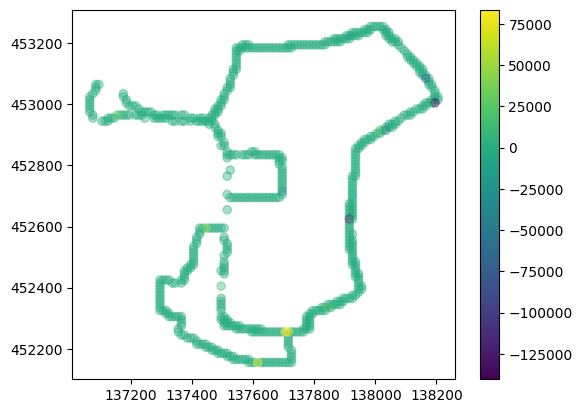

In [60]:
gdf_pred.plot(column='ypred', alpha=0.4, legend=True)